In [0]:
import os

from tensorflow.keras import layers
from tensorflow.keras import Model
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
  
from tensorflow.keras.applications.inception_v3 import InceptionV3

local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

pre_trained_model = InceptionV3(input_shape = (150, 150, 3), 
                                include_top = False, 
                                weights = None)

pre_trained_model.load_weights(local_weights_file)

for layer in pre_trained_model.layers:
  layer.trainable = False
  
# pre_trained_model.summary()

last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

--2020-06-07 12:28:20--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.133.128, 2a00:1450:400c:c02::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.133.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M   118MB/s    in 0.7s    

2020-06-07 12:28:21 (118 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]

last layer output shape:  (None, 7, 7, 768)


In [0]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers

# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4))(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)                  
# Add a final sigmoid layer for classification
x = layers.Dense  (1, activation='sigmoid',kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4))(x)           

model = Model( pre_trained_model.input, x) 

model.compile(optimizer = Adam(), 
              loss = 'binary_crossentropy', 
              metrics = ['accuracy'])


In [0]:
import os
import zipfile
import random
import tensorflow as tf
from shutil import copyfile

!wget --no-check-certificate \
    "https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip" \
    -O "/tmp/cats-and-dogs.zip"

local_zip = '/tmp/cats-and-dogs.zip'
zip_ref   = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

print(len(os.listdir('/tmp/PetImages/Cat/')))
print(len(os.listdir('/tmp/PetImages/Dog/')))

try:
    os.mkdir('/tmp/cats-v-dogs')
    os.mkdir('/tmp/cats-v-dogs/training')
    os.mkdir('/tmp/cats-v-dogs/testing')
    os.mkdir('/tmp/cats-v-dogs/training/cats')
    os.mkdir('/tmp/cats-v-dogs/training/dogs')
    os.mkdir('/tmp/cats-v-dogs/testing/cats')
    os.mkdir('/tmp/cats-v-dogs/testing/dogs')
except OSError:
    pass


def split_data(SOURCE, TRAINING, TESTING, SPLIT_SIZE):
    files = []
    for filename in os.listdir(SOURCE):
        file = SOURCE + filename
        if os.path.getsize(file) > 0:
            files.append(filename)
        else:
            print(filename + " is zero length, so ignoring.")

    training_length = int(len(files) * SPLIT_SIZE)
    testing_length = int(len(files) - training_length)
    shuffled_set = random.sample(files, len(files))
    training_set = shuffled_set[0:training_length]
    testing_set = shuffled_set[:testing_length]

    for filename in training_set:
        this_file = SOURCE + filename
        destination = TRAINING + filename
        copyfile(this_file, destination)

    for filename in testing_set:
        this_file = SOURCE + filename
        destination = TESTING + filename
        copyfile(this_file, destination)


CAT_SOURCE_DIR = "/tmp/PetImages/Cat/"
TRAINING_CATS_DIR = "/tmp/cats-v-dogs/training/cats/"
TESTING_CATS_DIR = "/tmp/cats-v-dogs/testing/cats/"
DOG_SOURCE_DIR = "/tmp/PetImages/Dog/"
TRAINING_DOGS_DIR = "/tmp/cats-v-dogs/training/dogs/"
TESTING_DOGS_DIR = "/tmp/cats-v-dogs/testing/dogs/"

split_size = .9
split_data(CAT_SOURCE_DIR, TRAINING_CATS_DIR, TESTING_CATS_DIR, split_size)
split_data(DOG_SOURCE_DIR, TRAINING_DOGS_DIR, TESTING_DOGS_DIR, split_size)

print('Total training cats: '+str(len(os.listdir("/tmp/cats-v-dogs/training/cats/"))))
print('Total training dogs: '+str(len(os.listdir("/tmp/cats-v-dogs/training/dogs/"))))
print('Total validation cats: '+str(len(os.listdir("/tmp/cats-v-dogs/testing/cats/"))))
print('Total validation dogs: '+str(len(os.listdir("/tmp/cats-v-dogs/testing/dogs/"))))

from keras.preprocessing.image import ImageDataGenerator
TRAINING_DIR = "/tmp/cats-v-dogs/training/"
# Experiment with your own parameters here to really try to drive it to 99.9% accuracy or better
train_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(TRAINING_DIR,
                                                    batch_size=100,
                                                    class_mode='binary',
                                                    target_size=(150, 150))

VALIDATION_DIR = "/tmp/cats-v-dogs/testing/"
# Experiment with your own parameters here to really try to drive it to 99.9% accuracy or better
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_directory(VALIDATION_DIR,
                                                              batch_size=100,
                                                              class_mode='binary',
                                                              target_size=(150, 150))

from tensorflow.keras.optimizers import Adam

model.compile(loss='binary_crossentropy',
              optimizer = 'Adam',
              metrics = ['acc']
              )

--2020-06-07 12:28:31--  https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip
Resolving download.microsoft.com (download.microsoft.com)... 104.101.100.142, 2a02:26f0:7b:89d::e59, 2a02:26f0:7b:895::e59
Connecting to download.microsoft.com (download.microsoft.com)|104.101.100.142|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 824894548 (787M) [application/octet-stream]
Saving to: ‘/tmp/cats-and-dogs.zip’

/tmp/cats-and-dogs. 100%[===================>] 786.68M  64.6MB/s    in 12s     

2020-06-07 12:28:43 (64.3 MB/s) - ‘/tmp/cats-and-dogs.zip’ saved [824894548/824894548]

12501
12501
666.jpg is zero length, so ignoring.
11702.jpg is zero length, so ignoring.
Total training cats: 12485
Total training dogs: 12488
Total validation cats: 3407
Total validation dogs: 3386


Using TensorFlow backend.


Found 24971 images belonging to 2 classes.
Found 6793 images belonging to 2 classes.


In [0]:
history = model.fit(
            train_generator,
            validation_data = validation_generator,
            epochs = 15,
            verbose = 1)

Epoch 1/15
 16/250 [>.............................] - ETA: 1:20 - loss: 3.5905 - acc: 0.8263

/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 32 bytes but only got 0. Skipping tag 270
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only

250/250 [==============================] - 120s 480ms/step - loss: 1.0930 - acc: 0.9525 - val_loss: 0.3902 - val_acc: 0.9766
Epoch 2/15
250/250 [==============================] - 116s 463ms/step - loss: 0.3094 - acc: 0.9741 - val_loss: 0.2476 - val_acc: 0.9901
Epoch 3/15
250/250 [==============================] - 115s 461ms/step - loss: 0.2422 - acc: 0.9791 - val_loss: 0.2459 - val_acc: 0.9800
Epoch 4/15
250/250 [==============================] - 114s 456ms/step - loss: 0.2353 - acc: 0.9795 - val_loss: 0.2284 - val_acc: 0.9900
Epoch 5/15
250/250 [==============================] - 114s 454ms/step - loss: 0.2227 - acc: 0.9826 - val_loss: 0.2006 - val_acc: 0.9903
Epoch 6/15
250/250 [==============================] - 113s 453ms/step - loss: 0.2081 - acc: 0.9851 - val_loss: 0.2009 - val_acc: 0.9898
Epoch 7/15
250/250 [==============================] - 113s 454ms/step - loss: 0.1942 - acc: 0.9849 - val_loss: 0.2109 - val_acc: 0.9819
Epoch 8/15
250/250 [==============================] - 114s 

In [0]:
model.evaluate(validation_generator)

68/68 [==============================] - 24s 351ms/step - loss: 0.1428 - acc: 0.9948


[0.14280067384243011, 0.9948476552963257]

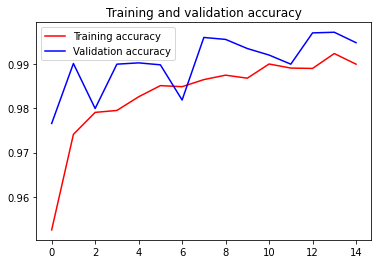

<Figure size 432x288 with 0 Axes>

In [0]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()